# Исследование технологического процесса очистки золота

# Задача

Нужно подготовить прототип модели машинного обучения для компании, которая разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Следует использовать данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Нам необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

# План

**1. Подготовка данных.**

    1.1. Открытие файлов и их изучение.
    1.2. Проверка правильности рассчета эффективности обогащения. Вычисление эффективности на обучающей выборке для признака rougher.output.recovery. Поиск MAE между нашими расчётами и значением признака.
    1.3. Анализ признаков, недоступных в тестовой выборке.
    1.4. Предобработка данных.
    
**2. Анализ данных.**

    2.1. Поиск и устранение аномалий.
    2.2. Исследование изменения концентрации элементов на каждом этапе.
    2.3. Анализ распределения размеров гранул на обучающей и тестовой выборках.
    2.4. Исследование суммарных концентраций.
    
**3. Построение модели.**

    3.1. Написание функции для вычисления итогового sMAPE.
    3.2. Обучение и проверка разных моделей.

## Подготовка данных

### Откроем файлы и изучим их.

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyRegressor

In [2]:
train_data = pd.read_csv('/datasets/gold_industry_train.csv')
test_data = pd.read_csv('/datasets/gold_industry_test.csv')
industry_data = pd.read_csv('/datasets/gold_industry_full.csv')

In [3]:
print(train_data.info())
train_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


In [4]:
print(test_data.info())
test_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2017-12-09 14:59:59,4.365491,6.158718,3.875727,39.135119,555.820208,94.544358,6.146982,9.308612,1196.238112,...,23.018622,-500.492702,20.020205,-500.220296,17.963512,-499.939490,12.990306,-500.080993,19.990336,-499.191575
1,2017-12-09 15:59:59,4.362781,6.048130,3.902537,39.713906,544.731687,123.742430,6.210119,9.297709,1201.904177,...,23.024963,-501.153409,20.054122,-500.314711,17.979515,-499.272871,12.992404,-499.976268,20.013986,-500.625471
2,2017-12-09 16:59:59,5.081681,6.082745,4.564078,37.208683,558.155110,82.610855,7.363824,9.003562,1200.826926,...,22.993827,-501.559663,20.029144,-500.000662,18.012723,-500.024764,13.016445,-500.058432,19.973767,-501.394155
3,2017-12-09 17:59:59,5.145949,6.084374,4.768124,36.808874,539.713765,77.984784,6.927072,8.955597,1199.292489,...,23.032807,-501.287889,19.977466,-500.159903,17.980463,-500.504602,12.949071,-500.009937,20.010332,-508.337973
4,2017-12-09 18:59:59,5.735249,6.165220,4.512346,37.810642,558.713584,86.434874,7.823471,7.490356,1198.005449,...,23.001911,-499.947838,20.023735,-499.713680,17.990955,-500.334769,13.007523,-499.968459,19.995999,-499.788805


In [5]:
print(industry_data.info())
industry_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   rougher.input.feed_au                               19439 non-null  float64
 2   rougher.input.feed_ag                               19439 non-null  float64
 3   rougher.input.feed_pb                               19339 non-null  float64
 4   rougher.input.feed_sol                              19340 non-null  float64
 5   rougher.input.feed_rate                             19428 non-null  float64
 6   rougher.input.feed_size                             19294 non-null  float64
 7   rougher.input.floatbank10_sulfate                   19405 non-null  float64
 8   rougher.input.floatbank10_xanthate                  19431 non-null  float64


,date,rougher.input.feed_au,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_sol,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.state.floatbank10_a_air,...,secondary_cleaner.output.tail_sol,final.output.concentrate_au,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.recovery,final.output.tail_au,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol
0,2016-01-15 00:00:00,6.486150,6.100378,2.284912,36.808594,523.546326,55.486599,11.986616,6.007990,999.706909,...,8.764648,42.192020,6.055403,9.889648,5.507324,70.541216,2.143149,10.411962,0.895447,16.904297
1,2016-01-15 01:00:00,6.478583,6.161113,2.266033,35.753385,525.290581,57.278666,11.971193,6.005766,1000.286398,...,9.001494,42.701629,6.029369,9.968944,5.257781,69.266198,2.224930,10.462676,0.927452,16.634514
2,2016-01-15 02:00:00,6.362222,6.116455,2.159622,35.971630,530.026610,57.510649,11.920603,6.197377,999.719565,...,8.842896,42.657501,6.055926,10.213995,5.383759,68.116445,2.257889,10.507046,0.953716,16.208849
3,2016-01-15 03:00:00,6.118189,6.043309,2.037807,36.862241,542.590390,57.792734,11.630094,6.203177,999.814770,...,9.122857,42.689819,6.047977,9.977019,4.858634,68.347543,2.146849,10.422762,0.883763,16.532835
4,2016-01-15 04:00:00,5.663707,6.060915,1.786875,34.347666,540.531893,56.047189,10.957755,6.198826,999.678690,...,8.871028,42.774141,6.148599,10.142511,4.939416,66.927016,2.055292,10.360302,0.792826,16.525686


### Проверим, что эффективность обогащения рассчитана правильно. Вычислим её на обучающей выборке для признака rougher.output.recovery. Найдем MAE между нашими расчётами и значением признака. Опишем выводы.

In [6]:
c = train_data['rougher.output.concentrate_au']
f = train_data['rougher.input.feed_au']
t = train_data['rougher.output.tail_au']

train_rougher_output_recovery = (c*(f-t))/(f*(c-t))*100
print(train_rougher_output_recovery.head(10))
print(train_data['rougher.output.recovery'].head(5))

0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
5    88.156912
6    88.168065
7    87.668336
8    87.035862
9    88.280699
dtype: float64
0    87.107763
1    86.843261
2    86.842308
3    87.226430
4    86.688794
Name: rougher.output.recovery, dtype: float64


In [7]:
mae = mean_absolute_error(train_rougher_output_recovery, train_data['rougher.output.recovery'])
print(mae)

9.83758577644259e-15


**Промежуточные выводы**

Мы проверили расчет эффективоности обогащения, среднее абсолютное отклонение получилось очень низким. Значит расчеты верны.

### Проанализируем признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14579 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14579 non-null  object 
 1   rougher.input.feed_au                               14579 non-null  float64
 2   rougher.input.feed_ag                               14579 non-null  float64
 3   rougher.input.feed_pb                               14507 non-null  float64
 4   rougher.input.feed_sol                              14502 non-null  float64
 5   rougher.input.feed_rate                             14572 non-null  float64
 6   rougher.input.feed_size                             14478 non-null  float64
 7   rougher.input.floatbank10_sulfate                   14548 non-null  float64
 8   rougher.input.floatbank10_xanthate                  14572 non-null  float64


In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4860 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4860 non-null   object 
 1   rougher.input.feed_au                       4860 non-null   float64
 2   rougher.input.feed_ag                       4860 non-null   float64
 3   rougher.input.feed_pb                       4832 non-null   float64
 4   rougher.input.feed_sol                      4838 non-null   float64
 5   rougher.input.feed_rate                     4856 non-null   float64
 6   rougher.input.feed_size                     4816 non-null   float64
 7   rougher.input.floatbank10_sulfate           4857 non-null   float64
 8   rougher.input.floatbank10_xanthate          4859 non-null   float64
 9   rougher.state.floatbank10_a_air             4859 non-null   float64
 10  rougher.stat

**Промежуточные выводы**

В тестовой выборке содержатся данные с этапами rougher, primary_cleaner и secondary_cleaner. В обучающей также есть этап final.

В тестовой выборке содержатся данные с типами параметра input и state. В обучающей также есть параметры output и calculation.

Т.е. в тестовой выборке нет целевого признака recovery и значений параметров после всех этапов очистки.

Это связано с тем, что тестовая выборка имитирует работу модели в реальных условиях протекания технологического процесса, и целевая метрика вычисляется только в работающей системе.

В обучающей выборке есть все данные, т.к. целевой признак вычисляется по историческим данным.

### Проведем предобработку данных.

In [10]:
train_data.hist(figsize=(200,200), bins=50);

In [11]:
test_data.hist(figsize=(200,200), bins=50);

#### Избавимся от пропусков.

In [12]:
# Посчитаем долю пропусков по столбцам
(train_data.isna().sum() / len(train_data)).sort_values(ascending=False)

secondary_cleaner.output.tail_sol           0.063104
rougher.state.floatbank10_e_air             0.029426
rougher.input.floatbank11_xanthate          0.027917
primary_cleaner.output.concentrate_sol      0.018177
final.output.concentrate_sol                0.013170
                                              ...   
primary_cleaner.state.floatbank8_c_air      0.000000
primary_cleaner.state.floatbank8_c_level    0.000000
primary_cleaner.state.floatbank8_d_level    0.000000
primary_cleaner.output.concentrate_au       0.000000
primary_cleaner.state.floatbank8_b_level    0.000000
Length: 87, dtype: float64

In [13]:
(test_data.isna().sum() / len(test_data)).sort_values(ascending=False)

secondary_cleaner.state.floatbank2_a_air      0.025926
rougher.input.floatbank11_xanthate            0.009465
rougher.input.feed_size                       0.009053
primary_cleaner.input.xanthate                0.008848
rougher.input.feed_pb                         0.005761
rougher.input.feed_sol                        0.004527
primary_cleaner.input.depressant              0.001852
rougher.input.floatbank11_sulfate             0.001646
rougher.state.floatbank10_e_air               0.001440
rougher.input.feed_rate                       0.000823
rougher.input.floatbank10_sulfate             0.000617
primary_cleaner.state.floatbank8_d_air        0.000412
primary_cleaner.state.floatbank8_c_air        0.000412
primary_cleaner.state.floatbank8_d_level      0.000206
secondary_cleaner.state.floatbank3_a_level    0.000206
secondary_cleaner.state.floatbank2_a_level    0.000206
secondary_cleaner.state.floatbank2_b_air      0.000206
secondary_cleaner.state.floatbank2_b_level    0.000206
secondary_

In [14]:
(industry_data.isna().sum() / len(industry_data)).sort_values(ascending=False)

secondary_cleaner.output.tail_sol           0.089922
rougher.input.floatbank11_xanthate          0.023304
rougher.state.floatbank10_e_air             0.022429
primary_cleaner.output.concentrate_sol      0.019034
secondary_cleaner.state.floatbank2_a_air    0.011317
                                              ...   
rougher.output.tail_sol                     0.000000
primary_cleaner.input.feed_size             0.000000
rougher.input.feed_au                       0.000000
primary_cleaner.output.concentrate_au       0.000000
date                                        0.000000
Length: 87, dtype: float64

Пропусков менеее 10%, значит можно от них избавиться.

In [15]:
train_data = train_data.dropna()
(train_data.isna().sum() / len(train_data)).sort_values(ascending=False)

date                                                  0.0
primary_cleaner.output.tail_sol                       0.0
secondary_cleaner.state.floatbank3_b_level            0.0
secondary_cleaner.state.floatbank3_b_air              0.0
secondary_cleaner.state.floatbank3_a_level            0.0
                                                     ... 
rougher.output.concentrate_au                         0.0
rougher.calculation.au_pb_ratio                       0.0
rougher.calculation.floatbank11_sulfate_to_au_feed    0.0
rougher.calculation.floatbank10_sulfate_to_au_feed    0.0
final.output.tail_sol                                 0.0
Length: 87, dtype: float64

In [16]:
test_data = test_data.dropna()
(test_data.isna().sum() / len(test_data)).sort_values(ascending=False)

date                                          0.0
primary_cleaner.state.floatbank8_a_air        0.0
primary_cleaner.state.floatbank8_b_air        0.0
primary_cleaner.state.floatbank8_b_level      0.0
primary_cleaner.state.floatbank8_c_air        0.0
primary_cleaner.state.floatbank8_c_level      0.0
primary_cleaner.state.floatbank8_d_air        0.0
primary_cleaner.state.floatbank8_d_level      0.0
secondary_cleaner.state.floatbank2_a_air      0.0
secondary_cleaner.state.floatbank2_a_level    0.0
secondary_cleaner.state.floatbank2_b_air      0.0
secondary_cleaner.state.floatbank2_b_level    0.0
secondary_cleaner.state.floatbank3_a_air      0.0
secondary_cleaner.state.floatbank3_a_level    0.0
secondary_cleaner.state.floatbank3_b_air      0.0
secondary_cleaner.state.floatbank3_b_level    0.0
secondary_cleaner.state.floatbank4_a_air      0.0
secondary_cleaner.state.floatbank4_a_level    0.0
secondary_cleaner.state.floatbank4_b_air      0.0
secondary_cleaner.state.floatbank4_b_level    0.0


In [17]:
industry_data = industry_data.dropna()

In [18]:
(industry_data.isna().sum() / len(industry_data)).sort_values(ascending=False)

date                                                  0.0
primary_cleaner.output.tail_sol                       0.0
secondary_cleaner.state.floatbank3_b_level            0.0
secondary_cleaner.state.floatbank3_b_air              0.0
secondary_cleaner.state.floatbank3_a_level            0.0
                                                     ... 
rougher.output.concentrate_au                         0.0
rougher.calculation.au_pb_ratio                       0.0
rougher.calculation.floatbank11_sulfate_to_au_feed    0.0
rougher.calculation.floatbank10_sulfate_to_au_feed    0.0
final.output.tail_sol                                 0.0
Length: 87, dtype: float64

In [19]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12337 entries, 0 to 14578
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                12337 non-null  object 
 1   rougher.input.feed_au                               12337 non-null  float64
 2   rougher.input.feed_ag                               12337 non-null  float64
 3   rougher.input.feed_pb                               12337 non-null  float64
 4   rougher.input.feed_sol                              12337 non-null  float64
 5   rougher.input.feed_rate                             12337 non-null  float64
 6   rougher.input.feed_size                             12337 non-null  float64
 7   rougher.input.floatbank10_sulfate                   12337 non-null  float64
 8   rougher.input.floatbank10_xanthate                  12337 non-null  float64


In [20]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4537 entries, 0 to 4859
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4537 non-null   object 
 1   rougher.input.feed_au                       4537 non-null   float64
 2   rougher.input.feed_ag                       4537 non-null   float64
 3   rougher.input.feed_pb                       4537 non-null   float64
 4   rougher.input.feed_sol                      4537 non-null   float64
 5   rougher.input.feed_rate                     4537 non-null   float64
 6   rougher.input.feed_size                     4537 non-null   float64
 7   rougher.input.floatbank10_sulfate           4537 non-null   float64
 8   rougher.input.floatbank10_xanthate          4537 non-null   float64
 9   rougher.state.floatbank10_a_air             4537 non-null   float64
 10  rougher.stat

#### Проверим данные на наличие дубликатов.

In [21]:
train_data.duplicated().sum()

0

In [22]:
test_data.duplicated().sum()

0

**Промежуточные выводы**

Мы избавились от пропусков, дубликатов не обнаружили. 

по гистограммам для каждого признака видно, что большинство данных распределено не нормально, скошенно, либо встречается одно характерное значение.

## Анализ данных

### Избавимся от аномалий

#### Рассмотрим график "ящик с усами" для каждого металла, чтобы определить аномальные значения

count    12337.000000
mean         8.526306
std          1.821282
min          0.010000
25%          7.087555
50%          8.370199
75%          9.947442
max         13.731330
Name: rougher.input.feed_au, dtype: float64


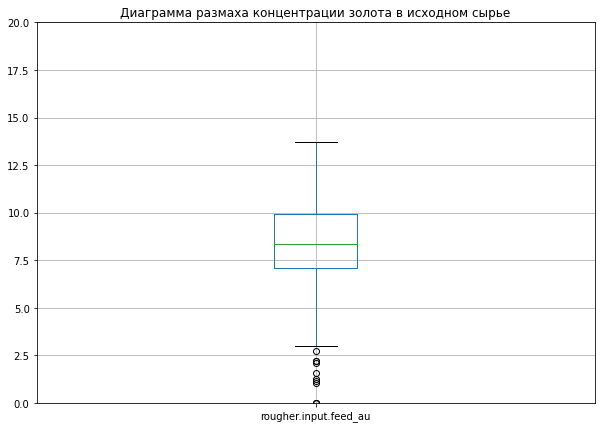

In [23]:
print(train_data['rougher.input.feed_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0, 20);
plt.title('Диаграмма размаха концентрации золота в исходном сырье');
pd.DataFrame(data=train_data['rougher.input.feed_au']).boxplot();

count    12337.000000
mean        19.955100
std          3.916161
min          0.000000
25%         19.136818
50%         20.505897
75%         21.928527
max         28.824507
Name: rougher.output.concentrate_au, dtype: float64


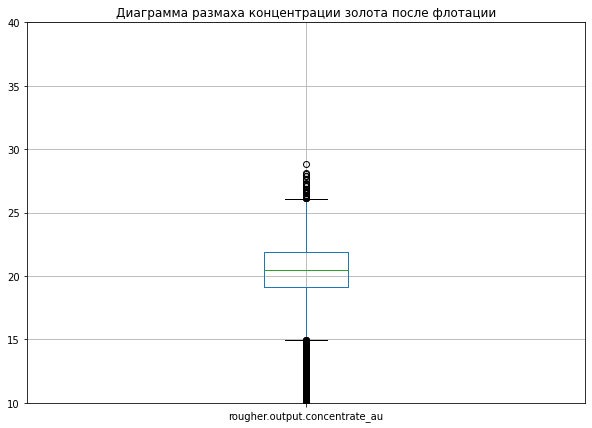

In [24]:
print(train_data['rougher.output.concentrate_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(10, 40);
plt.title('Диаграмма размаха концентрации золота после флотации');
pd.DataFrame(data=train_data['rougher.output.concentrate_au']).boxplot();

count    12337.000000
mean         1.886382
std          0.608757
min          0.070251
25%          1.508610
50%          1.861181
75%          2.236193
max          6.023451
Name: rougher.output.tail_au, dtype: float64


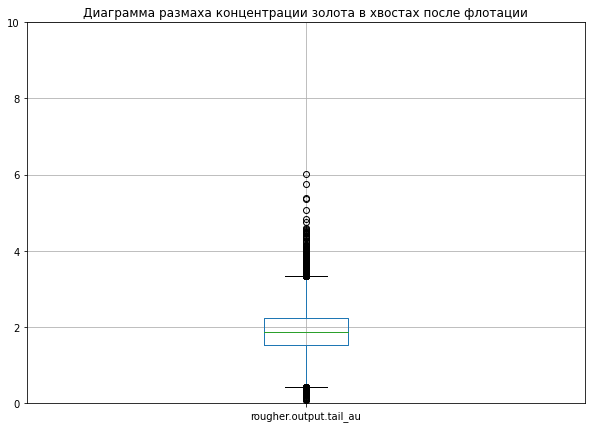

In [25]:
print(train_data['rougher.output.tail_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0, 10);
plt.title('Диаграмма размаха концентрации золота в хвостах после флотации');
pd.DataFrame(data=train_data['rougher.output.tail_au']).boxplot();

count    12337.000000
mean        32.009648
std          5.393016
min          0.000000
25%         30.256478
50%         32.657458
75%         34.853186
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64


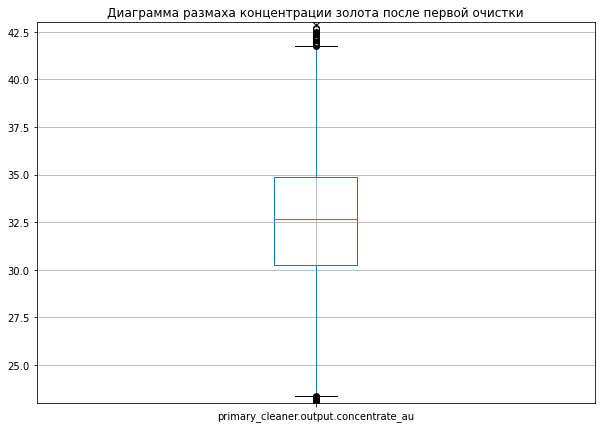

In [26]:
print(train_data['primary_cleaner.output.concentrate_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(23, 43);
plt.title('Диаграмма размаха концентрации золота после первой очистки');
pd.DataFrame(data=train_data['primary_cleaner.output.concentrate_au']).boxplot();

count    12337.000000
mean         3.970547
std          1.517921
min          0.000000
25%          2.990397
50%          3.707253
75%          4.666219
max         17.788925
Name: primary_cleaner.output.tail_au, dtype: float64


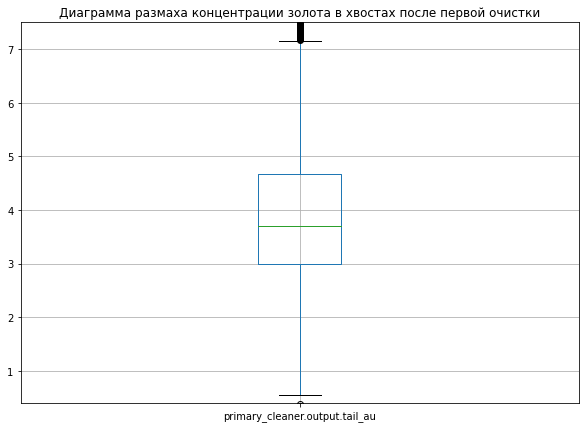

In [27]:
print(train_data['primary_cleaner.output.tail_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0.4, 7.5);
plt.title('Диаграмма размаха концентрации золота в хвостах после первой очистки');
pd.DataFrame(data=train_data['primary_cleaner.output.tail_au']).boxplot();

count    12337.000000
mean         4.379992
std          2.258689
min          0.000000
25%          3.201359
50%          4.073555
75%          5.088088
max         26.811643
Name: secondary_cleaner.output.tail_au, dtype: float64


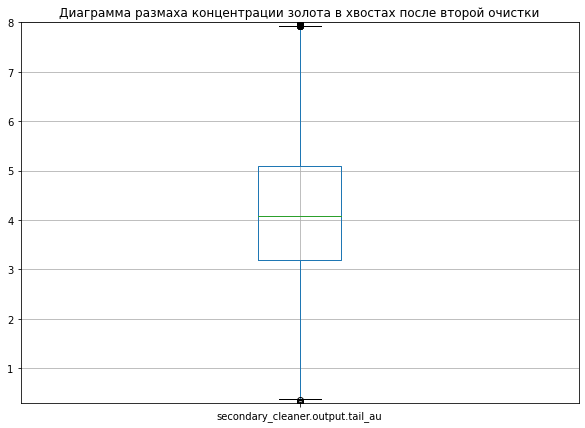

In [28]:
print(train_data['secondary_cleaner.output.tail_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0.3, 8);
plt.title('Диаграмма размаха концентрации золота в хвостах после второй очистки');
pd.DataFrame(data=train_data['secondary_cleaner.output.tail_au']).boxplot();

count    12337.000000
mean        44.264355
std          4.405221
min          0.000000
25%         43.406787
50%         44.982441
75%         46.253263
max         51.233068
Name: final.output.concentrate_au, dtype: float64


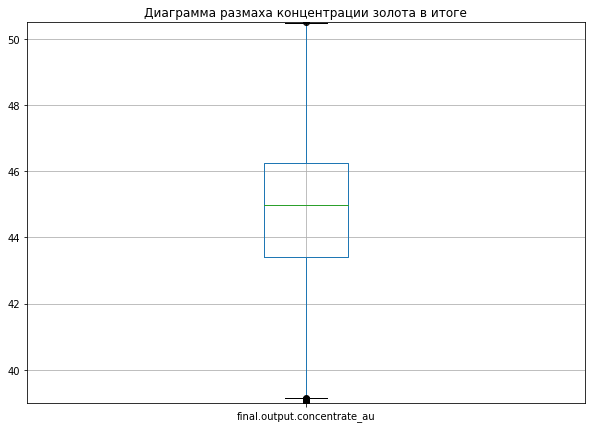

In [29]:
print(train_data['final.output.concentrate_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(39, 50.5);
plt.title('Диаграмма размаха концентрации золота в итоге');
pd.DataFrame(data=train_data['final.output.concentrate_au']).boxplot();

count    12337.000000
mean         3.136678
std          0.845181
min          0.000000
25%          2.568418
50%          3.069658
75%          3.625025
max          8.245022
Name: final.output.tail_au, dtype: float64


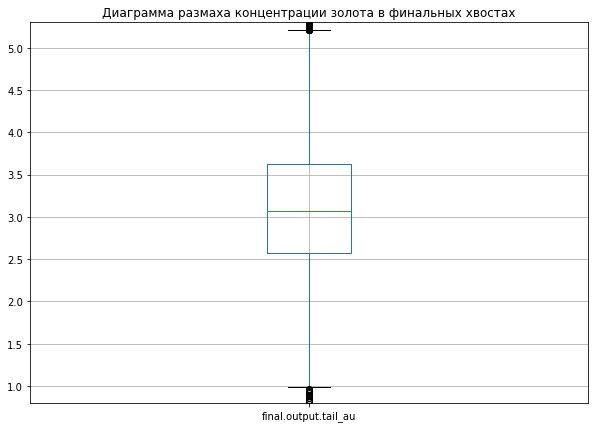

In [30]:
print(train_data['final.output.tail_au'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0.8, 5.3);
plt.title('Диаграмма размаха концентрации золота в финальных хвостах');
pd.DataFrame(data=train_data['final.output.tail_au']).boxplot();

Нормальные значения концентрации золота в исходном сырье находятся в диапазоне от 3 до 13,7.

После флотации от 15 до 26.

В хвостах после флотации от 0,5 до 3,5.

После первой очистки от 23 до 42.

В хвостах после первой очистки от 0,5 до 7,1.

В хвостах после второй очистки от 0,4 до 7,9.

В итоге от 39 до 50.5.

В финальных хвостах от 1 до 5.2.

count    12337.000000
mean         8.988052
std          1.909020
min          0.010000
25%          7.438985
50%          8.876414
75%         10.389965
max         14.596026
Name: rougher.input.feed_ag, dtype: float64


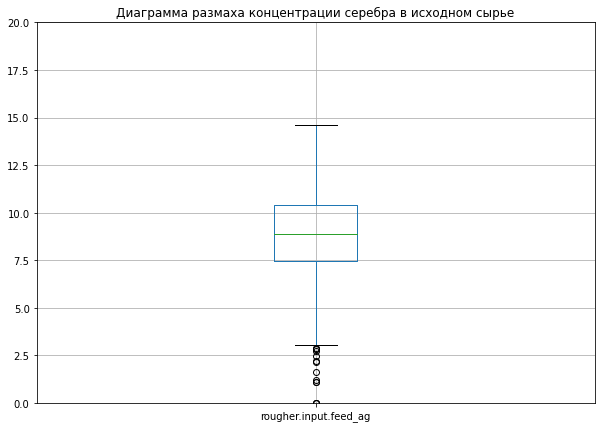

In [31]:
print(train_data['rougher.input.feed_ag'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0, 20);
plt.title('Диаграмма размаха концентрации серебра в исходном сырье');
pd.DataFrame(data=train_data['rougher.input.feed_ag']).boxplot();

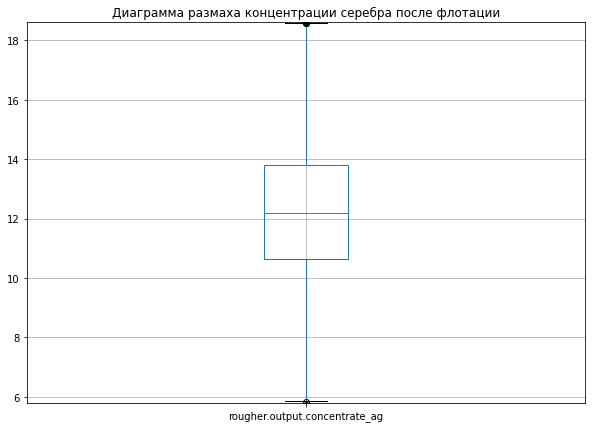

In [32]:
plt.figure(figsize=(10,7));
plt.ylim(5.8, 18.6);
plt.title('Диаграмма размаха концентрации серебра после флотации');
pd.DataFrame(data=train_data['rougher.output.concentrate_ag']).boxplot();

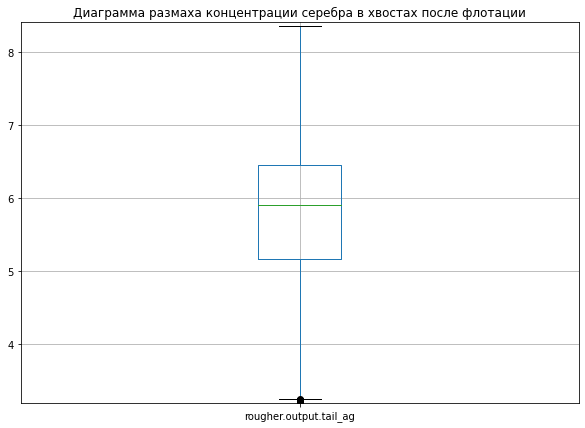

In [33]:
plt.figure(figsize=(10,7));
plt.ylim(3.2, 8.4);
plt.title('Диаграмма размаха концентрации серебра в хвостах после флотации');
pd.DataFrame(data=train_data['rougher.output.tail_ag']).boxplot();

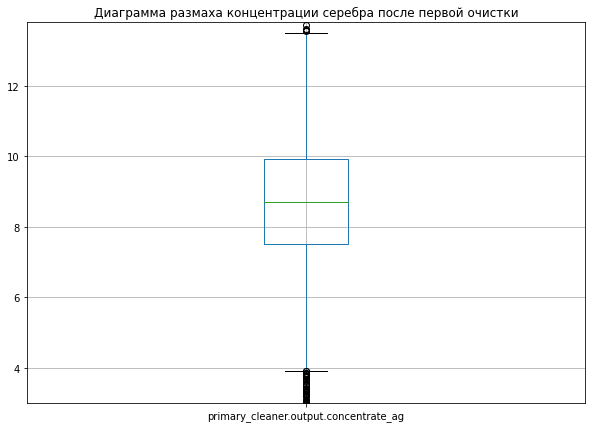

In [34]:
plt.figure(figsize=(10,7));
plt.ylim(3, 13.8);
plt.title('Диаграмма размаха концентрации серебра после первой очистки');
pd.DataFrame(data=train_data['primary_cleaner.output.concentrate_ag']).boxplot();

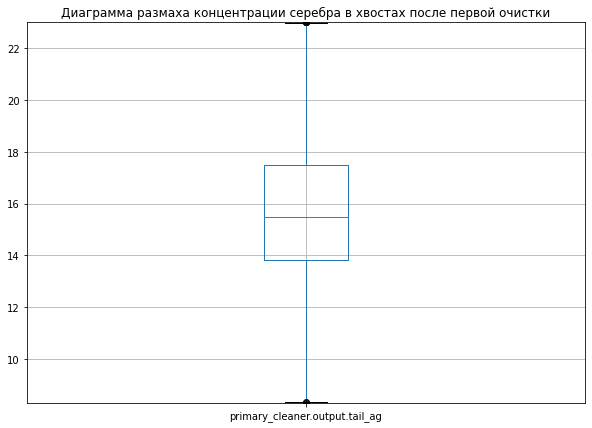

In [35]:
plt.figure(figsize=(10,7));
plt.ylim(8.3, 23);
plt.title('Диаграмма размаха концентрации серебра в хвостах после первой очистки');
pd.DataFrame(data=train_data['primary_cleaner.output.tail_ag']).boxplot();

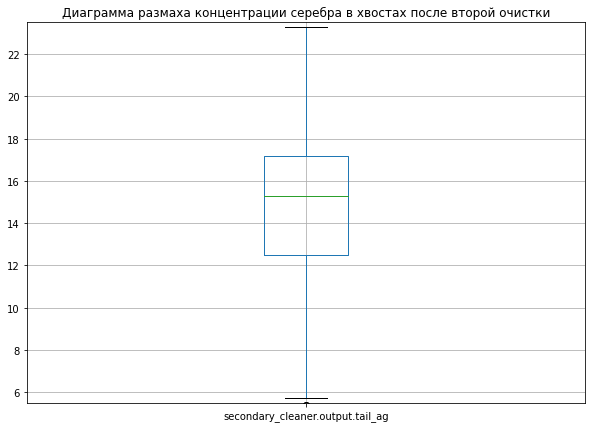

In [36]:
plt.figure(figsize=(10,7));
plt.ylim(5.5, 23.5);
plt.title('Диаграмма размаха концентрации серебра в хвостах после второй очистки');
pd.DataFrame(data=train_data['secondary_cleaner.output.tail_ag']).boxplot();

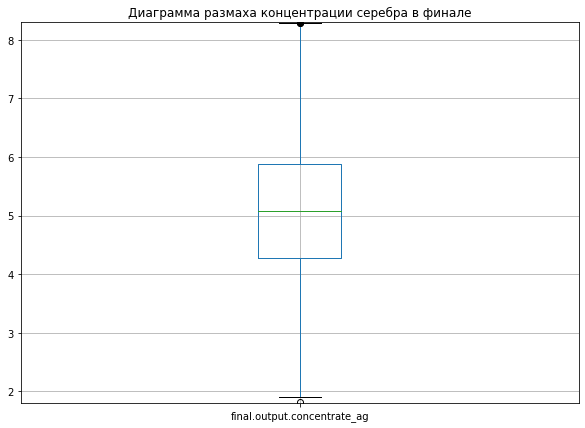

In [37]:
plt.figure(figsize=(10,7));
plt.ylim(1.8, 8.3);
plt.title('Диаграмма размаха концентрации серебра в финале');
pd.DataFrame(data=train_data['final.output.concentrate_ag']).boxplot();

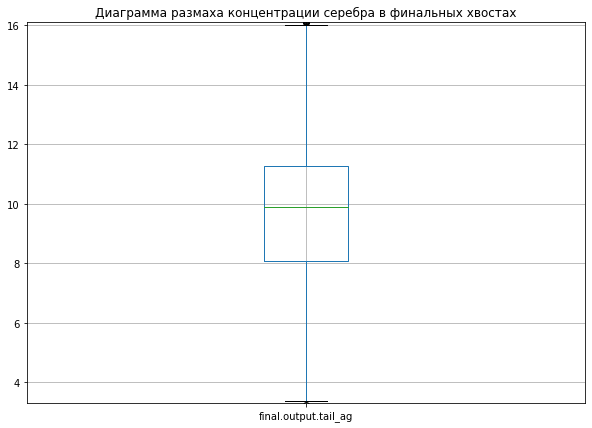

In [38]:
plt.figure(figsize=(10,7));
plt.ylim(3.3, 16.1);
plt.title('Диаграмма размаха концентрации серебра в финальных хвостах');
pd.DataFrame(data=train_data['final.output.tail_ag']).boxplot();

Нормальные значения концентрации серебра находятся в диапазоне от 3 до 14,6.

После флотации от 5.8 до 18.6.

В хвостах после флотации от 3.2 до 8.4.

После первой очистки от 3.9 до 13.8.

В хвостах после первой очистки от 8.3 до 23.

В хвостах после второй очистки от 5.5 до 23.5.

В итоге от 1.8 до 8.3.

В финальных хвостах от 3.3 до 16.1.

rougher.output.concentrate_au, rougher.output.tail_au, primary_cleaner.output.concentrate_au, primary_cleaner.output.tail_au, secondary_cleaner.output.tail_au, final.output.concentrate_au, final.output.tail_au

count    12337.000000
mean         3.645455
std          1.044827
min          0.010000
25%          2.929227
50%          3.583839
75%          4.278124
max          7.052325
Name: rougher.input.feed_pb, dtype: float64


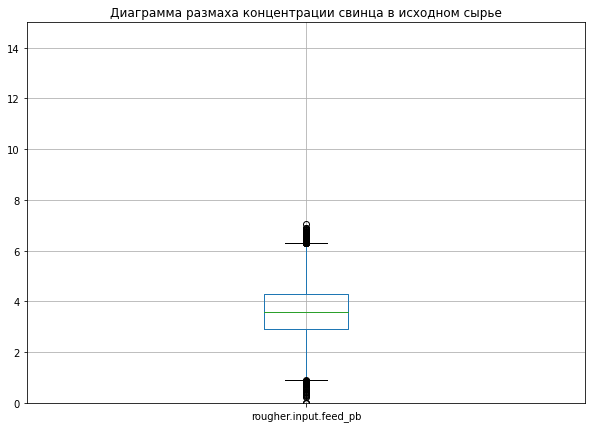

In [39]:
print(train_data['rougher.input.feed_pb'].describe())
plt.figure(figsize=(10,7));
plt.ylim(0, 15);
plt.title('Диаграмма размаха концентрации свинца в исходном сырье');
pd.DataFrame(data=train_data['rougher.input.feed_pb']).boxplot();

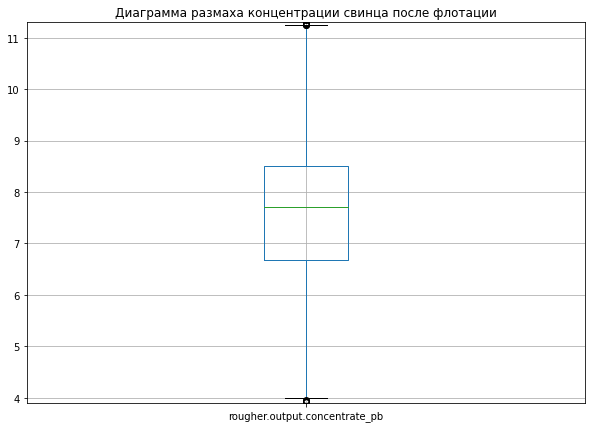

In [40]:
plt.figure(figsize=(10,7));
plt.ylim(3.9, 11.3);
plt.title('Диаграмма размаха концентрации свинца после флотации');
pd.DataFrame(data=train_data['rougher.output.concentrate_pb']).boxplot();

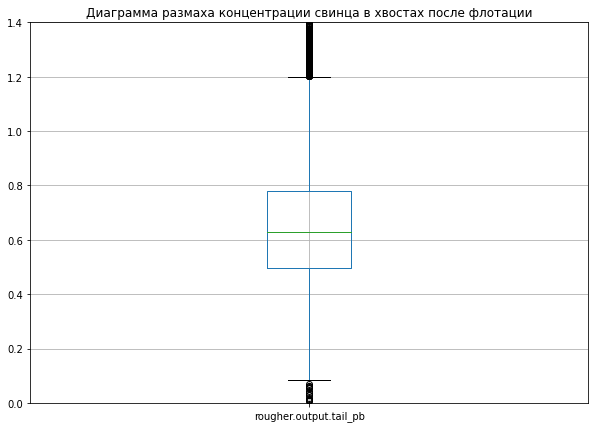

In [41]:
plt.figure(figsize=(10,7));
plt.ylim(0, 1.4);
plt.title('Диаграмма размаха концентрации свинца в хвостах после флотации');
pd.DataFrame(data=train_data['rougher.output.tail_pb']).boxplot();

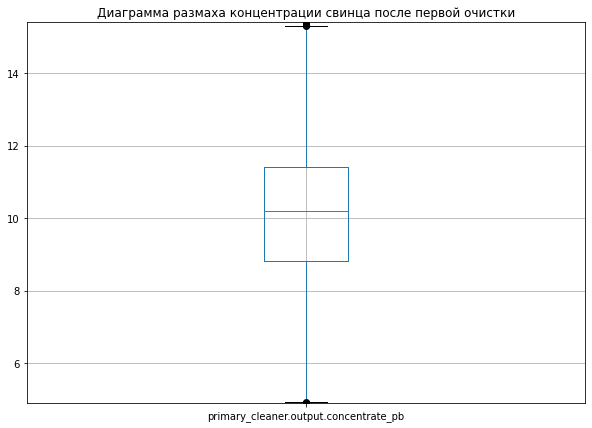

In [42]:
plt.figure(figsize=(10,7));
plt.ylim(4.9, 15.4);
plt.title('Диаграмма размаха концентрации свинца после первой очистки');
pd.DataFrame(data=train_data['primary_cleaner.output.concentrate_pb']).boxplot();

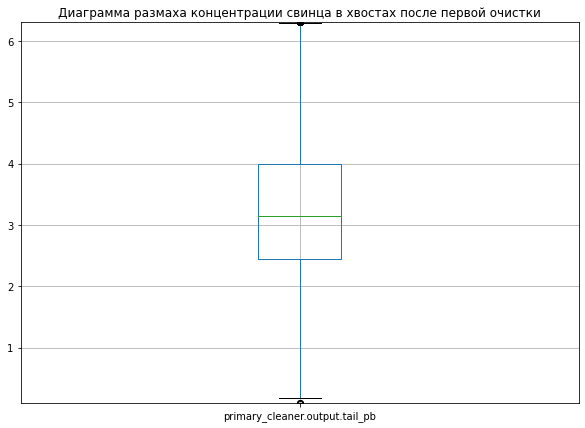

In [43]:
plt.figure(figsize=(10,7));
plt.ylim(0.1, 6.3);
plt.title('Диаграмма размаха концентрации свинца в хвостах после первой очистки');
pd.DataFrame(data=train_data['primary_cleaner.output.tail_pb']).boxplot();

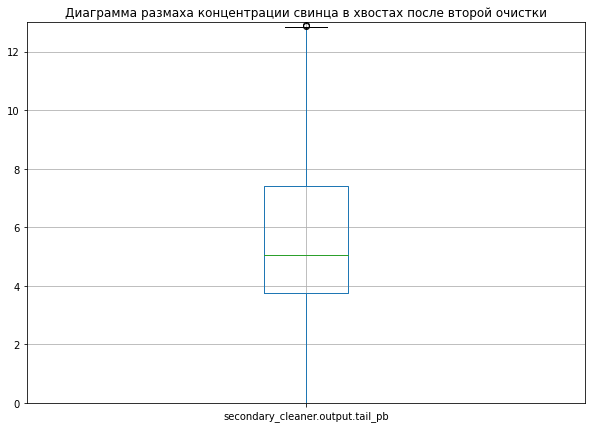

In [44]:
plt.figure(figsize=(10,7));
plt.ylim(0, 13);
plt.title('Диаграмма размаха концентрации свинца в хвостах после второй очистки');
pd.DataFrame(data=train_data['secondary_cleaner.output.tail_pb']).boxplot();

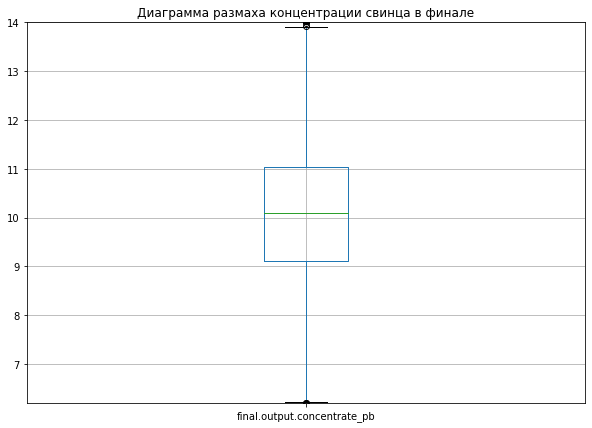

In [45]:
plt.figure(figsize=(10,7));
plt.ylim(6.2, 14);
plt.title('Диаграмма размаха концентрации свинца в финале');
pd.DataFrame(data=train_data['final.output.concentrate_pb']).boxplot();

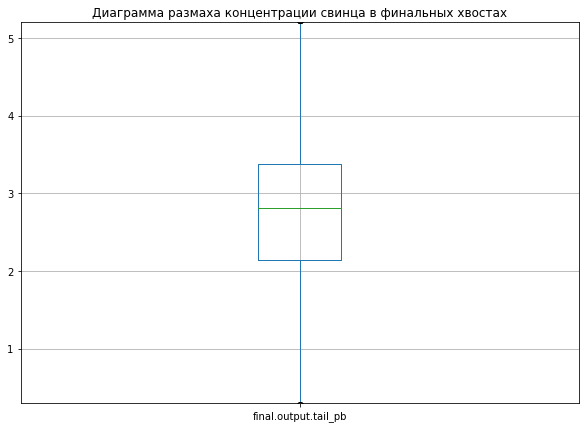

In [46]:
plt.figure(figsize=(10,7));
plt.ylim(0.3, 5.2);
plt.title('Диаграмма размаха концентрации свинца в финальных хвостах');
pd.DataFrame(data=train_data['final.output.tail_pb']).boxplot();

Нормальные значения концентрации свинца находятся в диапазоне от 1 до 6,3.

После флотации от 3.9 до 11.3.

В хвостах после флотации от 0.1 до 1.4.

После первой очистки от 4.9, 15.4.

В хвостах после первой очистки от 0.1 до 6.3.

В хвостах после второй очистки от 0 до 13.

В итоге от 6.2, 14.

В финальных хвостах от 0.3 до 5.2.

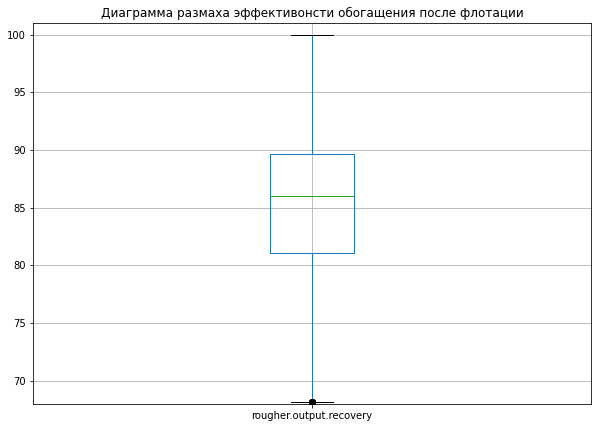

In [47]:
plt.figure(figsize=(10,7));
plt.ylim(68, 101);
plt.title('Диаграмма размаха эффективонсти обогащения после флотации');
pd.DataFrame(data=train_data['rougher.output.recovery']).boxplot();

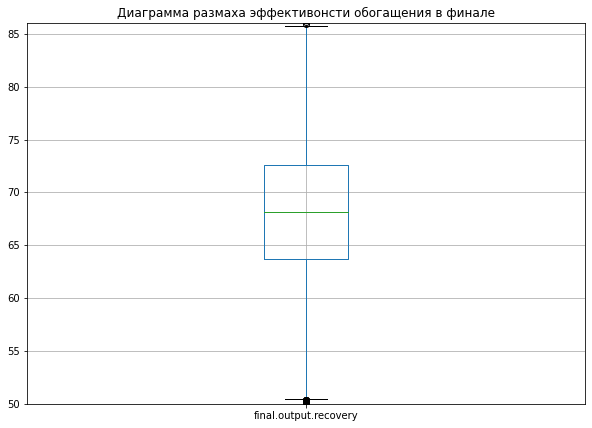

In [48]:
plt.figure(figsize=(10,7));
plt.ylim(50, 86);
plt.title('Диаграмма размаха эффективонсти обогащения в финале');
pd.DataFrame(data=train_data['final.output.recovery']).boxplot();

#### Удалим значения выходящие за рамки нормальных.

In [49]:
train_data = train_data[(train_data['rougher.input.feed_au'] >= 3) &(train_data['rougher.input.feed_au'] <= 13.7)]
train_data = train_data[(train_data['rougher.input.feed_ag'] >= 3) &(train_data['rougher.input.feed_ag'] <= 14.6)]
train_data = train_data[(train_data['rougher.input.feed_pb'] >= 1) &(train_data['rougher.input.feed_pb'] <= 6.3)]

train_data = train_data[(train_data['rougher.output.concentrate_au'] >= 15) &(train_data['rougher.output.concentrate_au'] <= 26)]
train_data = train_data[(train_data['rougher.output.concentrate_ag'] >= 5.8) &(train_data['rougher.output.concentrate_ag'] <= 18.6)]
train_data = train_data[(train_data['rougher.output.concentrate_pb'] >= 3.9) &(train_data['rougher.output.concentrate_pb'] <= 11.3)]

train_data = train_data[(train_data['rougher.output.tail_au'] >= 0.5) &(train_data['rougher.output.tail_au'] <= 3.5)]
train_data = train_data[(train_data['rougher.output.tail_ag'] >= 3.2) &(train_data['rougher.output.tail_ag'] <= 8.4)]
train_data = train_data[(train_data['rougher.output.tail_pb'] >= 0.1) &(train_data['rougher.output.tail_pb'] <= 1.4)]

train_data = train_data[(train_data['primary_cleaner.output.concentrate_au'] >= 23) &(train_data['primary_cleaner.output.concentrate_au'] <= 42)]
train_data = train_data[(train_data['primary_cleaner.output.concentrate_ag'] >= 3.9) &(train_data['primary_cleaner.output.concentrate_ag'] <= 13.8)]
train_data = train_data[(train_data['primary_cleaner.output.concentrate_pb'] >= 4.9) &(train_data['primary_cleaner.output.concentrate_pb'] <= 15.4)]

train_data = train_data[(train_data['primary_cleaner.output.tail_au'] >= 0.5) &(train_data['primary_cleaner.output.tail_au'] <= 7.1)]
train_data = train_data[(train_data['primary_cleaner.output.tail_ag'] >= 8.3) &(train_data['primary_cleaner.output.tail_ag'] <= 23)]
train_data = train_data[(train_data['primary_cleaner.output.tail_pb'] >= 0.1) &(train_data['primary_cleaner.output.tail_pb'] <= 6.3)]

train_data = train_data[(train_data['secondary_cleaner.output.tail_au'] >= 0.4) &(train_data['secondary_cleaner.output.tail_au'] <= 7.9)]
train_data = train_data[(train_data['secondary_cleaner.output.tail_ag'] >= 5.5) &(train_data['secondary_cleaner.output.tail_ag'] <= 23.5)]
train_data = train_data[(train_data['secondary_cleaner.output.tail_pb'] >= 0) &(train_data['secondary_cleaner.output.tail_pb'] <= 13)]

train_data = train_data[(train_data['final.output.concentrate_au'] >= 39) &(train_data['final.output.concentrate_au'] <= 50.5)]
train_data = train_data[(train_data['final.output.concentrate_ag'] >= 1.8) &(train_data['final.output.concentrate_ag'] <= 8.3)]
train_data = train_data[(train_data['final.output.concentrate_pb'] >= 6.2) &(train_data['final.output.concentrate_pb'] <= 14)]

train_data = train_data[(train_data['final.output.tail_au'] >= 1) &(train_data['final.output.tail_au'] <= 5.2)]
train_data = train_data[(train_data['final.output.tail_ag'] >= 3.3) &(train_data['final.output.tail_ag'] <= 16.1)]
train_data = train_data[(train_data['final.output.tail_pb'] >= 0.3) &(train_data['final.output.tail_pb'] <= 5.2)]

train_data = train_data[(train_data['rougher.output.recovery'] >= 68) &(train_data['rougher.output.recovery'] <= 101)]
train_data = train_data[(train_data['final.output.recovery'] >= 50) &(train_data['final.output.recovery'] <= 86)]


In [50]:
train_data = train_data[(train_data['rougher.input.feed_au'] >= 3) &(train_data['rougher.input.feed_au'] <= 13.7)]
train_data = train_data[(train_data['rougher.input.feed_ag'] >= 3) &(train_data['rougher.input.feed_ag'] <= 14.6)]
train_data = train_data[(train_data['rougher.input.feed_pb'] >= 1) &(train_data['rougher.input.feed_pb'] <= 6.3)]

In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8375 entries, 0 to 14565
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                8375 non-null   object 
 1   rougher.input.feed_au                               8375 non-null   float64
 2   rougher.input.feed_ag                               8375 non-null   float64
 3   rougher.input.feed_pb                               8375 non-null   float64
 4   rougher.input.feed_sol                              8375 non-null   float64
 5   rougher.input.feed_rate                             8375 non-null   float64
 6   rougher.input.feed_size                             8375 non-null   float64
 7   rougher.input.floatbank10_sulfate                   8375 non-null   float64
 8   rougher.input.floatbank10_xanthate                  8375 non-null   float64
 

#### Удалим строки, в которых концентрация золота в процессе обработки уменьшается

In [52]:
# Удалим строки, в которых концентрация золота в процессе обработки уменьшается
train_data = train_data[train_data['rougher.input.feed_au'] < train_data['rougher.output.concentrate_au']]
train_data = train_data[train_data['rougher.output.concentrate_au'] < train_data['primary_cleaner.output.concentrate_au']]
train_data = train_data[train_data['primary_cleaner.output.concentrate_au'] < train_data['final.output.concentrate_au']]

### Исследуем изменение концентрации элементов на каждом этапе

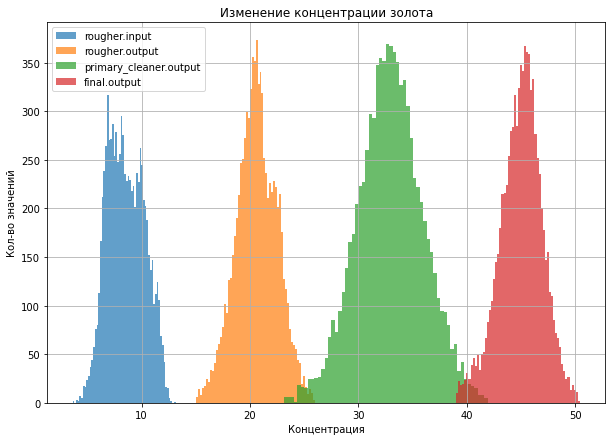

In [53]:
train_data['rougher.input.feed_au'].hist(figsize=(10,7), alpha=0.7, bins=60);
train_data['rougher.output.concentrate_au'].hist(figsize=(10,7), alpha=0.7, bins=60);
train_data['primary_cleaner.output.concentrate_au'].hist(figsize=(10,7), alpha=0.7, bins=60);
train_data['final.output.concentrate_au'].hist(figsize=(10,7), alpha=0.7, bins=60);
plt.xlabel("Концентрация");
plt.ylabel("Кол-во значений");
plt.legend(['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output']);
plt.title("Изменение концентрации золота");

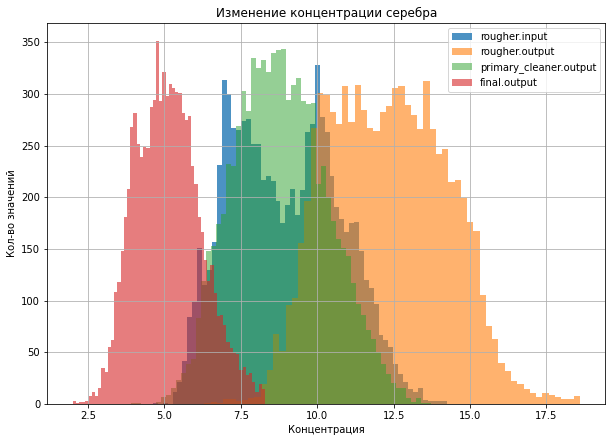

In [54]:
train_data['rougher.input.feed_ag'].hist(figsize=(10,7), alpha=0.8, bins=60);
train_data['rougher.output.concentrate_ag'].hist(figsize=(10,7), alpha=0.6, bins=60);
train_data['primary_cleaner.output.concentrate_ag'].hist(figsize=(10,7), alpha=0.5, bins=60);
train_data['final.output.concentrate_ag'].hist(figsize=(10,7), alpha=0.6, bins=60);
plt.xlabel("Концентрация");
plt.ylabel("Кол-во значений");
plt.legend(['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output']);
plt.title("Изменение концентрации серебра");

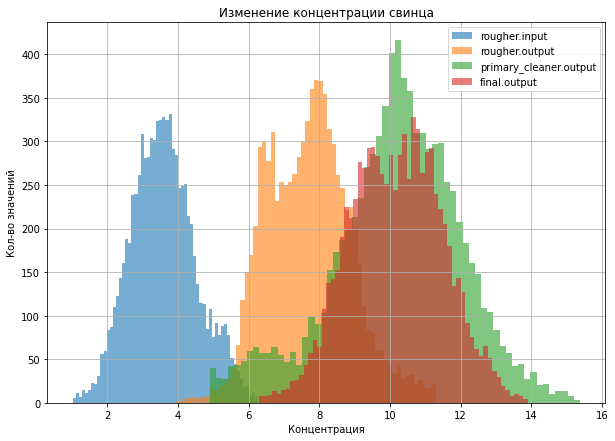

In [55]:
train_data['rougher.input.feed_pb'].hist(figsize=(10,7), alpha=0.6, bins=60);
train_data['rougher.output.concentrate_pb'].hist(figsize=(10,7), alpha=0.6, bins=60);
train_data['primary_cleaner.output.concentrate_pb'].hist(figsize=(10,7), alpha=0.6, bins=60);
train_data['final.output.concentrate_pb'].hist(figsize=(10,7), alpha=0.6, bins=60);
plt.xlabel("Концентрация");
plt.ylabel("Кол-во значений");
plt.legend(['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output']);
plt.title("Изменение концентрации свинца");

**Промежуточные выводы**

Концентрация золота после каждого этапа сильно увеличивается.

Концентрация серебра увеличивается после флотации, а затем уменьшается на последующих этапах.

Концентрация свинца немного увеличивается.

### Проанализируем распределения размеров гранул на обучающей и тестовой выборках

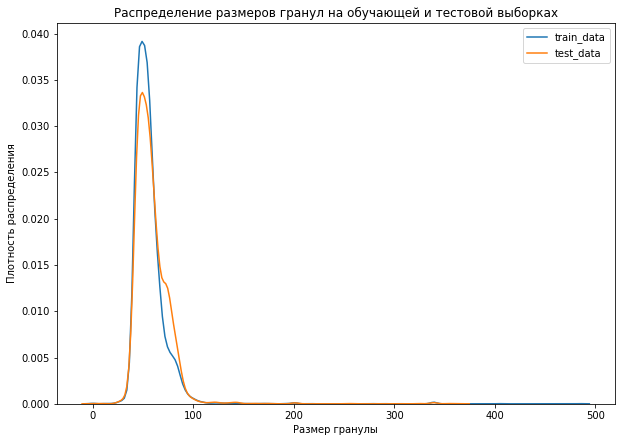

In [56]:
plt.figure(figsize=(10,7));
sns.kdeplot(data=train_data['rougher.input.feed_size'], alpha=0.7);
sns.kdeplot(data=test_data['rougher.input.feed_size'], alpha=0.7);
plt.xlabel("Размер гранулы");
plt.ylabel("Плотность распределения");
plt.legend(['train_data', 'test_data']);
plt.title("Распределение размеров гранул на обучающей и тестовой выборках");

**Промежуточные выводы**

Распределения размеров гранул исходного сырья на обучающей и тестовой выборках очень похожи.

### Исследуем суммарные концентрации

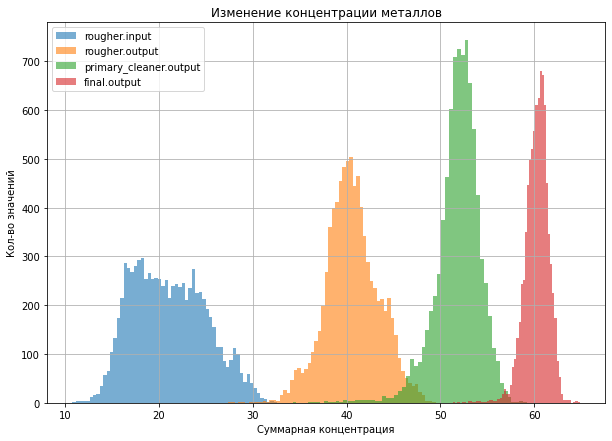

In [57]:
rougher_input = train_data['rougher.input.feed_au'] + train_data['rougher.input.feed_ag'] + train_data['rougher.input.feed_pb']
rougher_output = train_data['rougher.output.concentrate_au'] + train_data['rougher.output.concentrate_ag'] + train_data['rougher.output.concentrate_pb']
primary_cleaner = train_data['primary_cleaner.output.concentrate_au'] + train_data['primary_cleaner.output.concentrate_ag'] + train_data['primary_cleaner.output.concentrate_pb']
final = train_data['final.output.concentrate_au'] + train_data['final.output.concentrate_ag'] + train_data['final.output.concentrate_pb']

rougher_input.hist(figsize=(10,7), alpha=0.6, bins=60);
rougher_output.hist(figsize=(10,7), alpha=0.6, bins=60);
primary_cleaner.hist(figsize=(10,7), alpha=0.6, bins=60);
final.hist(figsize=(10,7), alpha=0.6, bins=60);
plt.xlabel("Суммарная концентрация");
plt.ylabel("Кол-во значений");
plt.legend(['rougher.input', 'rougher.output', 'primary_cleaner.output', 'final.output']);
plt.title("Изменение концентрации металлов");

**Промежуточные выводы**

Суммарная концентрация металлов растет с каждым этапом.

Итак, мы исследовали изменение концентрации элементов на каждом этапе обработки руды. Выяснилось, что концентрация золота после каждого этапа увеличивается, концентрация серебра увеличивается после флотации, а затем уменьшается на последующих этапах, концентрация свинца немного увеличивается.

Также мы исследовали распределение размеров гранул исходного сырья на обучающей и тестовой выборках и определили, что очень похожи.

Суммарные концентрации металлов на каждом этапе также увеличиваются.

## Построение модели

### Напишем функцию для вычисления итогового sMAPE

In [58]:
def smape(recovery, recovery_predict):
    summa = (abs(recovery - recovery_predict) / ((abs(recovery) + abs(recovery_predict))/2)).sum()
    summa *= 100
    summa /= len(recovery)
    return summa

In [59]:
def total_smape(rougher_smape, final_smape):
    return 0.25 * rougher_smape + 0.75 * final_smape

### Обучим и проверим несколько моделей

#### Избавимся от ненужных признаков для обучения модели, вычислив корреляцию. Восстановим недостающие в тестовой выборке данные по исходному датасету

In [60]:
test_data = test_data.merge(
    industry_data[['date', 'rougher.output.recovery', 'final.output.recovery']],
    on='date',
    how='left'
)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4537 entries, 0 to 4536
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        4537 non-null   object 
 1   rougher.input.feed_au                       4537 non-null   float64
 2   rougher.input.feed_ag                       4537 non-null   float64
 3   rougher.input.feed_pb                       4537 non-null   float64
 4   rougher.input.feed_sol                      4537 non-null   float64
 5   rougher.input.feed_rate                     4537 non-null   float64
 6   rougher.input.feed_size                     4537 non-null   float64
 7   rougher.input.floatbank10_sulfate           4537 non-null   float64
 8   rougher.input.floatbank10_xanthate          4537 non-null   float64
 9   rougher.state.floatbank10_a_air             4537 non-null   float64
 10  rougher.stat

In [61]:
# Удалим сталбец с датой, для модели он не понадобится
train_data = train_data.drop(['date'], axis=1)
test_data = test_data.drop(['date'], axis=1)

In [62]:
print(abs(test_data.corr()['final.output.recovery']).sort_values().head(60))

secondary_cleaner.state.floatbank6_a_air      0.000528
secondary_cleaner.state.floatbank3_a_level    0.002937
primary_cleaner.input.feed_size               0.003105
rougher.input.floatbank11_sulfate             0.007007
secondary_cleaner.state.floatbank6_a_level    0.008598
secondary_cleaner.state.floatbank3_b_level    0.008904
rougher.input.floatbank10_sulfate             0.013916
secondary_cleaner.state.floatbank2_a_level    0.014168
secondary_cleaner.state.floatbank2_b_level    0.024683
secondary_cleaner.state.floatbank4_a_level    0.033928
rougher.state.floatbank10_a_level             0.037480
secondary_cleaner.state.floatbank5_a_level    0.039261
primary_cleaner.state.floatbank8_b_level      0.039658
rougher.state.floatbank10_f_air               0.049574
primary_cleaner.state.floatbank8_d_level      0.050270
primary_cleaner.state.floatbank8_c_level      0.051176
secondary_cleaner.state.floatbank5_b_level    0.055567
secondary_cleaner.state.floatbank4_b_level    0.056552
primary_cl

Оставим только те столбцы, у которых корреляция с recovery более |0.1|.

In [63]:
test_data = test_data.drop(['secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank3_a_level',
                           'primary_cleaner.input.feed_size', 'rougher.input.floatbank11_sulfate',
                           'secondary_cleaner.state.floatbank6_a_level', 'secondary_cleaner.state.floatbank3_b_level',
                           'rougher.input.floatbank10_sulfate', 'secondary_cleaner.state.floatbank2_a_level',
                           'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank4_a_level',
                           'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank5_a_level',
                           'primary_cleaner.state.floatbank8_b_level', 'rougher.state.floatbank10_f_air',
                           'primary_cleaner.state.floatbank8_d_level', 'primary_cleaner.state.floatbank8_c_level',
                            'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank4_b_level', 
                            'primary_cleaner.state.floatbank8_a_level', 'rougher.state.floatbank10_e_level', 
                            'secondary_cleaner.state.floatbank5_b_air', 'rougher.state.floatbank10_f_level', 
                            'rougher.state.floatbank10_e_air', 'secondary_cleaner.state.floatbank3_b_air', 
                            'rougher.state.floatbank10_b_level', 'secondary_cleaner.state.floatbank5_a_air', 
                            'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level'], axis=1)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4537 entries, 0 to 4536
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rougher.input.feed_au                     4537 non-null   float64
 1   rougher.input.feed_ag                     4537 non-null   float64
 2   rougher.input.feed_pb                     4537 non-null   float64
 3   rougher.input.feed_sol                    4537 non-null   float64
 4   rougher.input.feed_rate                   4537 non-null   float64
 5   rougher.input.feed_size                   4537 non-null   float64
 6   rougher.input.floatbank10_xanthate        4537 non-null   float64
 7   rougher.state.floatbank10_a_air           4537 non-null   float64
 8   rougher.state.floatbank10_b_air           4537 non-null   float64
 9   rougher.state.floatbank10_c_air           4537 non-null   float64
 10  rougher.state.floatbank10_d_air     

In [64]:
train_data = train_data.drop(['secondary_cleaner.state.floatbank6_a_air', 'secondary_cleaner.state.floatbank3_a_level',
                           'primary_cleaner.input.feed_size', 'rougher.input.floatbank11_sulfate',
                           'secondary_cleaner.state.floatbank6_a_level', 'secondary_cleaner.state.floatbank3_b_level',
                           'rougher.input.floatbank10_sulfate', 'secondary_cleaner.state.floatbank2_a_level',
                           'secondary_cleaner.state.floatbank2_b_level', 'secondary_cleaner.state.floatbank4_a_level',
                           'rougher.state.floatbank10_a_level', 'secondary_cleaner.state.floatbank5_a_level',
                           'primary_cleaner.state.floatbank8_b_level', 'rougher.state.floatbank10_f_air',
                           'primary_cleaner.state.floatbank8_d_level', 'primary_cleaner.state.floatbank8_c_level',
                            'secondary_cleaner.state.floatbank5_b_level', 'secondary_cleaner.state.floatbank4_b_level', 
                            'primary_cleaner.state.floatbank8_a_level', 'rougher.state.floatbank10_e_level', 
                            'secondary_cleaner.state.floatbank5_b_air', 'rougher.state.floatbank10_f_level', 
                            'rougher.state.floatbank10_e_air', 'secondary_cleaner.state.floatbank3_b_air', 
                            'rougher.state.floatbank10_b_level', 'secondary_cleaner.state.floatbank5_a_air', 
                            'rougher.state.floatbank10_c_level', 'rougher.state.floatbank10_d_level'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8375 entries, 0 to 14565
Data columns (total 58 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   rougher.input.feed_au                               8375 non-null   float64
 1   rougher.input.feed_ag                               8375 non-null   float64
 2   rougher.input.feed_pb                               8375 non-null   float64
 3   rougher.input.feed_sol                              8375 non-null   float64
 4   rougher.input.feed_rate                             8375 non-null   float64
 5   rougher.input.feed_size                             8375 non-null   float64
 6   rougher.input.floatbank10_xanthate                  8375 non-null   float64
 7   rougher.state.floatbank10_a_air                     8375 non-null   float64
 8   rougher.state.floatbank10_b_air                     8375 non-null   float64
 

In [65]:
train_data = train_data.drop(['rougher.calculation.sulfate_to_au_concentrate', 'rougher.calculation.floatbank10_sulfate_to_au_feed',
                              'rougher.calculation.floatbank11_sulfate_to_au_feed', 'rougher.calculation.au_pb_ratio', 
                              'rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 
                              'rougher.output.concentrate_sol', 'rougher.output.tail_au', 'rougher.output.tail_ag', 
                              'rougher.output.tail_pb', 'rougher.output.tail_sol', 'primary_cleaner.output.concentrate_au', 
                              'primary_cleaner.output.concentrate_ag', 'primary_cleaner.output.concentrate_pb', 
                              'primary_cleaner.output.concentrate_sol', 'primary_cleaner.output.tail_au', 
                              'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb', 'primary_cleaner.output.tail_sol',
                              'secondary_cleaner.output.tail_au', 'secondary_cleaner.output.tail_ag', 
                              'secondary_cleaner.output.tail_pb', 'secondary_cleaner.output.tail_sol', 
                              'final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb', 
                              'final.output.concentrate_sol', 'final.output.tail_au', 'final.output.tail_ag', 
                              'final.output.tail_pb', 'final.output.tail_sol'], axis=1)
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8375 entries, 0 to 14565
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rougher.input.feed_au                     8375 non-null   float64
 1   rougher.input.feed_ag                     8375 non-null   float64
 2   rougher.input.feed_pb                     8375 non-null   float64
 3   rougher.input.feed_sol                    8375 non-null   float64
 4   rougher.input.feed_rate                   8375 non-null   float64
 5   rougher.input.feed_size                   8375 non-null   float64
 6   rougher.input.floatbank10_xanthate        8375 non-null   float64
 7   rougher.state.floatbank10_a_air           8375 non-null   float64
 8   rougher.state.floatbank10_b_air           8375 non-null   float64
 9   rougher.state.floatbank10_c_air           8375 non-null   float64
 10  rougher.state.floatbank10_d_air    

In [66]:
test_data.isna().sum().sort_values(ascending=False)

final.output.recovery                       780
rougher.output.recovery                     780
rougher.input.feed_ag                         0
secondary_cleaner.state.floatbank4_b_air      0
secondary_cleaner.state.floatbank4_a_air      0
secondary_cleaner.state.floatbank3_a_air      0
secondary_cleaner.state.floatbank2_b_air      0
secondary_cleaner.state.floatbank2_a_air      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.input.xanthate                0
rougher.input.feed_au                         0
primary_cleaner.input.sulfate                 0
rougher.input.floatbank11_xanthate            0
rougher.state.floatbank10_d_air               0
rougher.state.floatbank10_c_air               0
rougher.state.floatbank10_b_air               0
rougher.state.floatbank10_a_air               0
rougher.input.floatbank10_xanthate      

In [67]:
test_data = test_data.dropna()

#### Модель линейной регрессии

In [68]:
final_features_cross = train_data.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).values
final_target_cross = train_data['final.output.recovery'].values
rougher_features_cross = train_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).values
rougher_target_cross = train_data['rougher.output.recovery'].values

In [69]:
final_model_cross1 = LinearRegression()
smape_scorer = make_scorer(smape, greater_is_better=False)
final_scores1 = cross_val_score(final_model_cross1, final_features_cross, final_target_cross, cv=5, scoring=smape_scorer)
print(final_scores1)

rougher_model_cross1 = LinearRegression()
rougher_scores1 = cross_val_score(rougher_model_cross1, rougher_features_cross, rougher_target_cross, cv=5, scoring=smape_scorer)
print(rougher_scores1)

smape1 = total_smape(rougher_scores1.mean()*-1, final_scores1.mean()*-1)
smape1

[-6.20663424 -5.78296426 -5.11714653 -5.88548955 -6.42943018]
[-6.82300708 -3.61361288 -3.31551137 -4.6843808  -6.04087761]


5.6371191989328775

#### Дерово решений

In [70]:
best_final_model_cross2 = DecisionTreeRegressor(random_state=12345, max_depth=1)
best_depth2 = 0
best_smape2 = 100

i_depth = [None] + [i for i in range(2, 7)]

for i in i_depth:
    
    final_model_cross2 = DecisionTreeRegressor(random_state=12345, max_depth=i)
    final_scores2 = cross_val_score(final_model_cross2, final_features_cross, final_target_cross, cv=5, scoring=smape_scorer)
    
    rougher_model_cross2 = DecisionTreeRegressor(random_state=12345, max_depth=i)
    rougher_scores2 = cross_val_score(rougher_model_cross2, rougher_features_cross, rougher_target_cross, cv=5, scoring=smape_scorer)
    
    smape2 = total_smape(rougher_scores2.mean()*-1, final_scores2.mean()*-1)
    
    if smape2 < best_smape2:
        best_final_model_cross2 = final_model_cross2
        best_depth2 = i
        best_smape2 = smape2
        
print('depth:', best_depth2, 'smape:', best_smape2)

depth: 2 smape: 5.920096855935702


#### Случайный лес

In [71]:
best_final_model_cross3 = RandomForestRegressor(random_state=12345, n_estimators=1, max_depth=1)
best_est3 = 0
best_depth3 = 0
best_smape3 = 100

for est in range(100, 151, 50):
    for depth in i_depth:
        final_model_cross3 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        final_scores3 = cross_val_score(final_model_cross3, final_features_cross, final_target_cross, cv=5, scoring=smape_scorer)
        
        rougher_model_cross3 = RandomForestRegressor(random_state=12345, n_estimators=est, max_depth=depth)
        rougher_scores3 = cross_val_score(rougher_model_cross3, rougher_features_cross, rougher_target_cross, cv=5, scoring=smape_scorer)
        smape3 = total_smape(rougher_scores3.mean()*-1, final_scores3.mean()*-1)
        
        print('est:', est, 'depth:', depth, 'smape:', smape3)

    if smape3 < best_smape3:
        best_final_model_cross3 = final_model_cross3
        best_est3 = est
        best_depth3 = depth
        best_smape3 = smape3
print('est:', best_est3, 'depth:', best_depth3, 'smape:', best_smape3)

est: 100 depth: None smape: 6.004784822023229
est: 100 depth: 2 smape: 5.714225707771572
est: 100 depth: 3 smape: 5.831137956553745
est: 100 depth: 4 smape: 5.893773202127322
est: 100 depth: 5 smape: 5.966088168647257
est: 100 depth: 6 smape: 5.986276590056045
est: 150 depth: None smape: 5.979950066663048
est: 150 depth: 2 smape: 5.711256958654092
est: 150 depth: 3 smape: 5.827903613512368
est: 150 depth: 4 smape: 5.894372411343206
est: 150 depth: 5 smape: 5.949350197481282
est: 150 depth: 6 smape: 5.9711096641594175
est: 150 depth: 6 smape: 5.9711096641594175


Лучший результат показала модель линейной регрессии, итоговое sMape - 5,64.

#### Проверим модель линейной регрессии на тестовой выборке

In [72]:
final_features_train = train_data.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).values
final_target_train = train_data['final.output.recovery'].values
final_features_test = test_data.drop(['final.output.recovery', 'rougher.output.recovery'], axis=1).values
final_target_test = test_data['final.output.recovery'].values

rougher_features_train = train_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).values
rougher_target_train = train_data['rougher.output.recovery'].values
rougher_features_test = test_data.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1).values
rougher_target_test = test_data['rougher.output.recovery'].values

final_model = LinearRegression()
final_model.fit(final_features_train, final_target_train)
final_predicted_test = final_model.predict(final_features_test)
final_score = smape(final_target_test, final_predicted_test)
print(final_score)

rougher_model = LinearRegression()
rougher_model.fit(rougher_features_train, rougher_target_train)
rougher_predicted_test = rougher_model.predict(rougher_features_test)
rougher_score = smape(rougher_target_test, rougher_predicted_test)
print(rougher_score)

smape_score = total_smape(rougher_score, final_score)
print(smape_score)

6.944188612178621
4.145158649824536
6.2444311215901


Получили итоговое sMAPE 6.24.

#### Проверим результаты на константной модели

In [73]:
final_dummy_regr = DummyRegressor(strategy="mean")
final_dummy_regr.fit(final_features_train, final_target_train)
final_dummy_regr_predict = final_dummy_regr.predict(final_features_test)
final_dummy_score = smape(final_target_test, final_dummy_regr_predict)
print(final_dummy_score)

rougher_dummy_regr = DummyRegressor(strategy="mean")
rougher_dummy_regr.fit(rougher_features_train, rougher_target_train)
rougher_dummy_regr_predict = rougher_dummy_regr.predict(rougher_features_test)
rougher_dummy_score = smape(rougher_target_test, rougher_dummy_regr_predict)
print(rougher_dummy_score)

smape_dummy_score = total_smape(rougher_dummy_score, final_dummy_score)
print(smape_dummy_score)

8.391870914460307
5.916848665485945
7.773115352216717


На константной модели получили итоговое sMAPE 7.77.

## Выводы

В ходе исследования была проделана следующая работа:
- Мы проверили формулу вычисления эффективности обогащения, среднее абсолютное отклонение получилось очень низким. Значит расчеты верны.
- Выяснили, что в тестовую выборку не попали признаки с этапом final и типами параметра output и calculation. Это связано с тем, что тестовая выборка имитирует работу модели в реальных условиях протекания технологического процесса, и целевая метрика вычисляется только в работающей системе. В обучающей выборке есть все данные, т.к. целевой признак вычисляется по историческим данным.
- Провели предобработку данных: устранили пропуски, убедились в отсутствии дубликатов, устранили аномальные значения.
- Исследовали изменение концентрации элементов на каждом этапе: концентрация золота после каждого этапа увеличивается, концентрация серебра увеличивается после флотации, а затем уменьшается на последующих этапах, концентрация свинца немного увеличивается.
- Проанализировали распределения размеров гранул на обучающей и тестовой выборках, они оказались очень похожи.
- Исследовали суммарную концентрацию металлов: она растет с каждым этапом.
- Для вычисления итогового sMAPE мы написали функцию.
- Обучили и проверили модель линейной регресси, случайного леса и дерево решений. Лучший результат показала модель линейной регрессии, итоговая sMAPE на обучающей выборке составила 5.64. На тестовых данных итоговая sMAPE составила 6.24.
- Константная модель показала итоговое sMAPE 7.77. Т.е. результат тестирования нашей модели на тествой выборке лучше, чем результат константной модели.